Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [17]:
# Import pandas and read csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE


In [18]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [20]:
# keine Nullwerte
df.isnull().sum().max()

0

In [21]:
# Explore the features available in your datafram
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [22]:
# Count the occurrences of fraud and no fraud 
occ = df['Class'].value_counts()
occ

0    284315
1       492
Name: Class, dtype: int64

In [23]:
# Print the ratio of fraud cases
ratio = occ / len(df.index)
ratio

0    0.998273
1    0.001727
Name: Class, dtype: float64

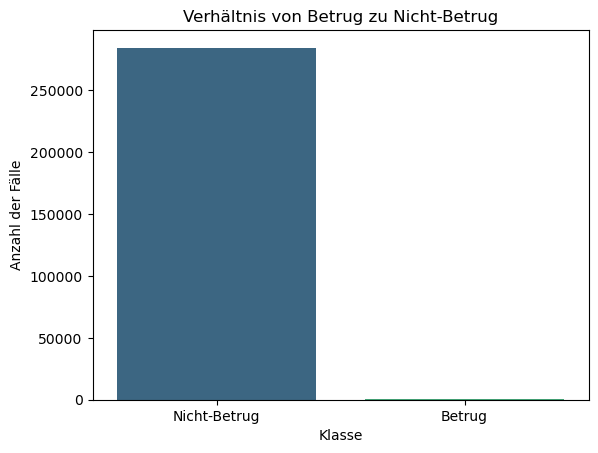

In [24]:
# plt.figure(figsize=(10, 6))
sns.barplot(x=occ.index, y=occ.values, palette='viridis')

# Plot anpassen
plt.title('Verhältnis von Betrug zu Nicht-Betrug')
plt.xlabel('Klasse')
plt.ylabel('Anzahl der Fälle')
plt.xticks([0, 1], ['Nicht-Betrug', 'Betrug'])
plt.show()

Note: Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

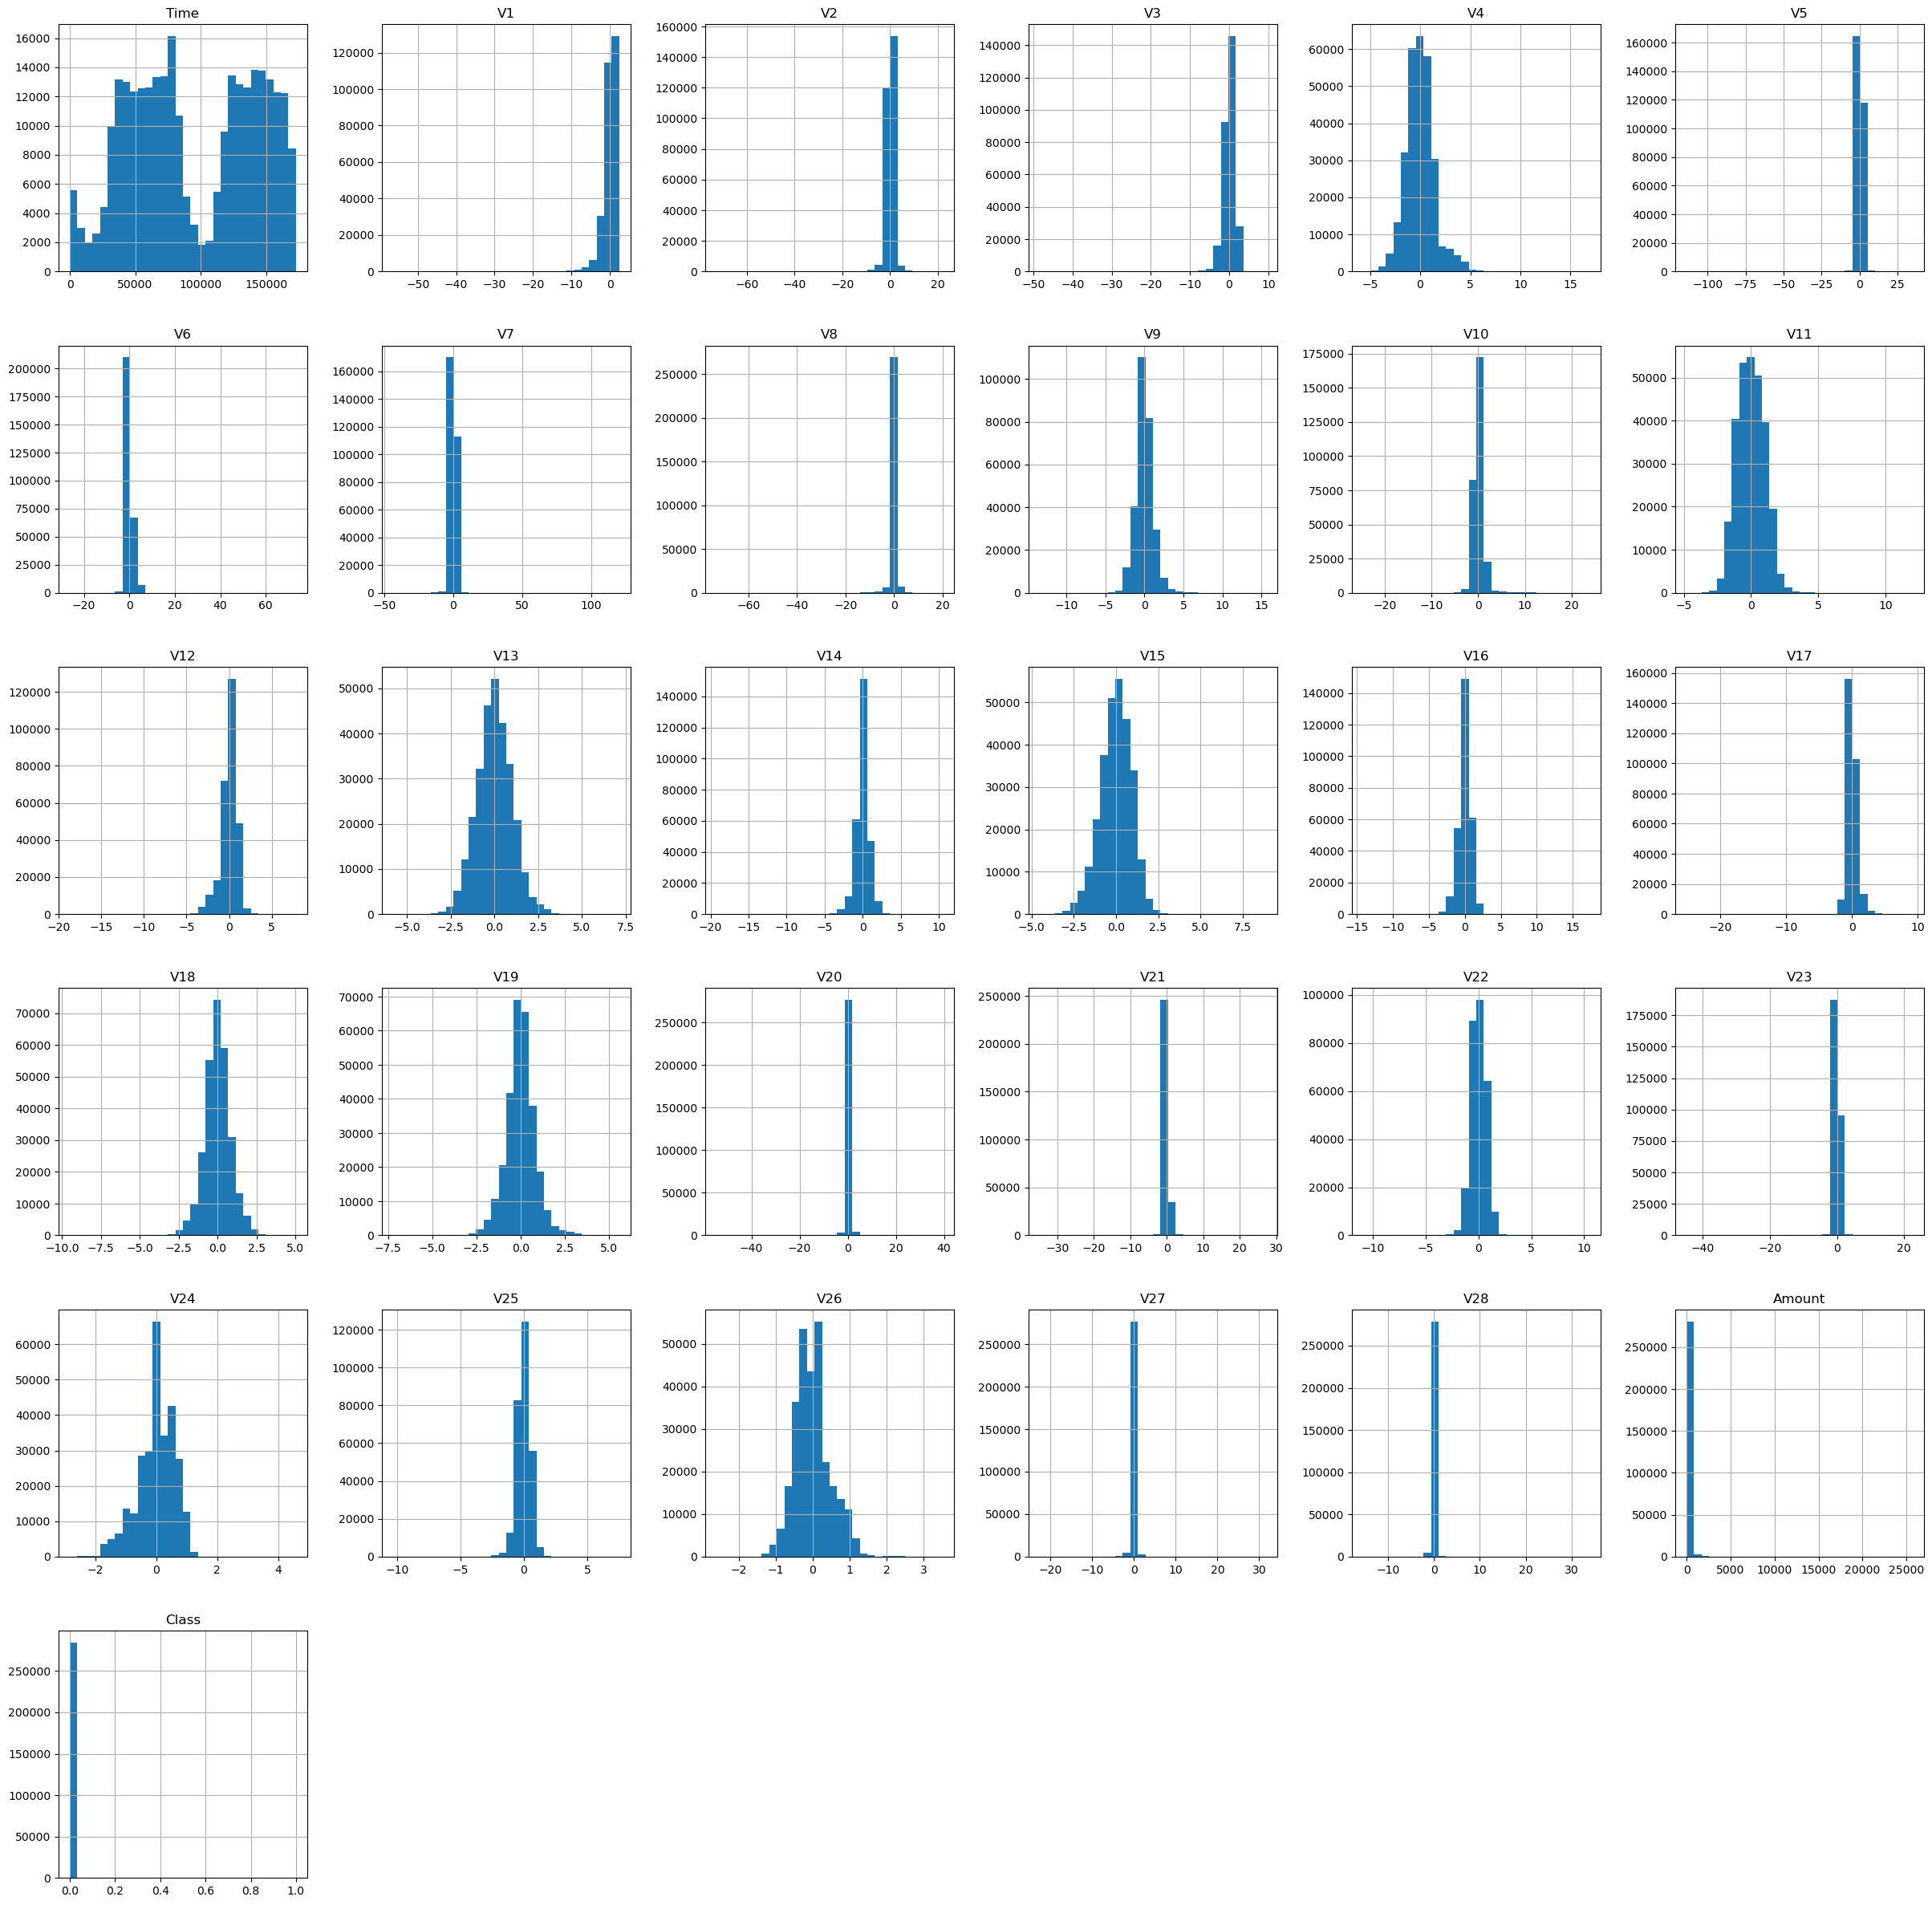

In [25]:
df.hist(bins=30, figsize=(30, 30))


In [26]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [27]:
from sklearn.preprocessing import RobustScaler

# Kopiere den DataFrame
new_df = df.copy()

# Robuste Skalierung für die Spalte "Amount"
new_df['Amount'] = RobustScaler().fit_transform(new_df['Amount'].to_numpy().reshape(-1, 1))

# Min-Max-Skalierung für die Spalte "Time"
time = new_df['Time']
new_df['Time'] = (time - time.min()) / (time.max() - time.min())

# Anzeigen des neuen DataFrames
new_df.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,0.548717,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.927124,0.001727
std,0.274828,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,3.495006,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-0.307413,0.000000
25%,0.313681,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-0.229162,0.000000
50%,0.490138,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000000,0.000000
75%,0.806290,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.770838,0.000000
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,358.683155,1.000000


In [28]:
# Define a function to train and evaluate the model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Obtain model predictions
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)[:, 1]
    
    # Print the classification report and confusion matrix
    print('Classification Report:\n', classification_report(y_test, predicted))
    conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
    print('Confusion Matrix:\n', conf_mat)
    
    # Calculate AUPRC
    precision, recall, _ = precision_recall_curve(y_test, predicted_prob)
    auprc = auc(recall, precision)
    print('AUPRC Score:', auprc)
    
    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'{model.__class__.__name__} (AUPRC = {auprc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

Logistic Regression Model:


/Users/sebastiangurgel/opt/anaconda3/envs/sebaenv1/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85295    12]
 [   50    86]]
AUPRC Score: 0.7880162636944473


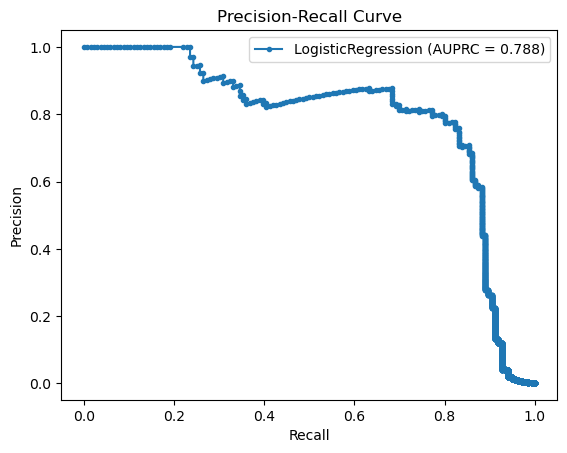

In [29]:
from sklearn.preprocessing import RobustScaler

# Copy the DataFrame
new_df = df.copy()

# Robust scaling for the "Amount" column
new_df['Amount'] = RobustScaler().fit_transform(new_df['Amount'].to_numpy().reshape(-1, 1))

# Min-Max scaling for the "Time" column
time = new_df['Time']
new_df['Time'] = (time - time.min()) / (time.max() - time.min())

# Define features (X) and target (y)
X = new_df.drop(columns=['Class'])
y = new_df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standard scaling for the features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model
logistic_regression_model = LogisticRegression()

# Train and evaluate logistic regression model
print("Logistic Regression Model:")
train_and_evaluate_model(logistic_regression_model, X_train_scaled, X_test_scaled, y_train, y_test)


XGBoost Model:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85299     8]
 [   25   111]]
AUPRC Score: 0.8894210896024344


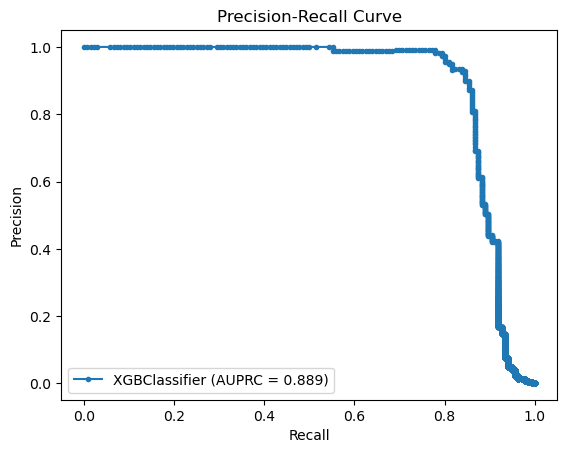

In [32]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgboost_model = XGBClassifier()

# Train and evaluate XGBoost model
print("XGBoost Model:")
train_and_evaluate_model(xgboost_model, X_train, X_test, y_train, y_test)


Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.84      0.89       136

    accuracy                           1.00     85443
   macro avg       0.98      0.92      0.95     85443
weighted avg       1.00      1.00      1.00     85443

Confusion Matrix:
 [[85302     5]
 [   22   114]]
AUPRC Score: 0.8991131619128299


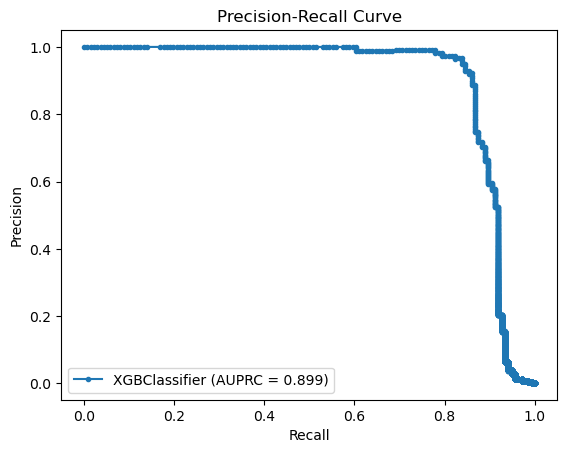

In [33]:


# Define the parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],               # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'n_estimators': [100, 200, 300],      # Number of trees
}

# Initialize XGBoost model
xgboost_model = XGBClassifier()

# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(xgboost_model, param_grid_xgb, cv=5, scoring='roc_auc')
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

# Train the model with the best parameters
best_model_xgb = XGBClassifier(**best_params_xgb)
best_model_xgb.fit(X_train, y_train)

# Evaluate the model
train_and_evaluate_model(best_model_xgb, X_train, X_test, y_train, y_test)



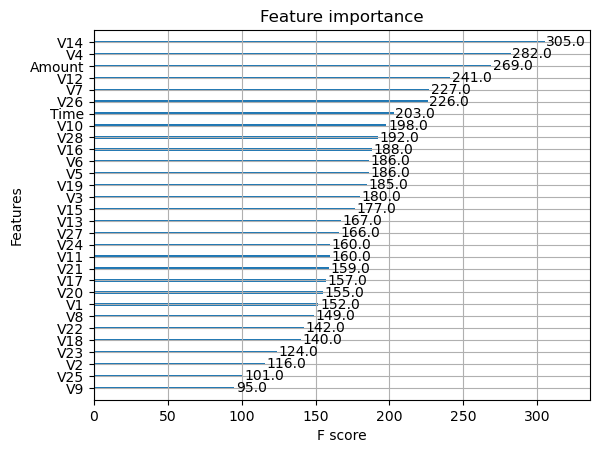

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(best_model_xgb)
plt.show()



It looks like the XGBoost model trained with the best parameters achieved an AUPRC score of approximately 0.896, which indicates good performance in identifying the minority class (frauds). The classification report shows high precision, recall, and F1-score for both the majority class (non-frauds) and the minority class (frauds). This suggests that the model can effectively distinguish between fraud and non-fraud transactions.

Here's a summary of the results:

AUPRC Score: 0.899 (Higher values indicate better performance, especially for imbalanced datasets)
Precision:
For class 0 (non-frauds): 1.00
For class 1 (frauds): 0.96
Recall (Sensitivity):
For class 0 (non-frauds): 1.00
For class 1 (frauds): 0.83
F1-score:
For class 0 (non-frauds): 1.00
For class 1 (frauds): 0.89
Overall, these results suggest that the XGBoost model with the specified hyperparameters performs well in identifying fraud transactions while maintaining high accuracy for non-fraud transactions.